In [1]:
import sys
import os

package_path = os.path.abspath(os.path.join('..', 'tlc'))

if package_path not in sys.path:
    sys.path.append(package_path)

from tlc import *

# Detailed balance limit (Shockley-Queisser limit)

* Shockley and Queisser proposed the efficiency limit of a single junction solar cell is a function of the band gap ([original paper here](https://doi.org/10.1063/1.1736034)).
This approach is based on several assumptions:
  - All photons with energies equal or larger than the band gap are absorbed.
  - Each absorbed photon creates one electron-hole pair.
  - All charge carriers can reach their respective contacts.
  - Only radiative recombination (band-to-band electron-hole recombination) is considered.

* Required inputs are:
    1.  Solar spectrum. The AM1.5g spectrum is used in this example (from [NREL](https://www.nrel.gov/grid/solar-resource/spectra.html)). But you can always input your specific spectrum.
    2.  Band gap of the bulk material.
    3.  Operation temperature ``T`` of the solar cell (with a default value of 300 K).


In [2]:
tlc_Sb2Se3_sq = tlc(1.419, T=300, l_sq=True)  #l_sq=True turns on the SQ mode
tlc_Sb2Se3_sq.calculate_rad()

print(tlc_Sb2Se3_sq)

Shockley-Queisser limit (SQ limit)
T: 300.0 K
E_gap: 1.4 eV
Thickness: 2000.0 nm
===
J_sc: 32.071 mA/cm^2
J0_rad: 1.22e-18 mA/cm^2
V_oc: 1.156 V
V_max, J_max: 1.059 V, 31.319 mA/cm^2
FF: 89.459%
Efficiency: 33.166%


# Radiative limit based on thickness-dependent absorptivity

* If you want to replace the step-like absorptivity by the real absorption, an extra file of optical absorption coefficient &alpha; as a function of energy is needed.
  
* The absorptivity *a* is calculated as *a*=1-exp(-2*αL*), where *L* is the film thickness (using the [SLME metric](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.108.068701)).

In [4]:
tlc.ALPHA_FILE = f"Sb2Se3/alpha.csv"

In [7]:
tlc_Sb2Se3_rad = tlc(1.419, T=300, thickness=500)
tlc_Sb2Se3_rad.calculate_rad()

print(tlc_Sb2Se3_rad)

Trap limited conversion efficiency (TLC)
T: 300.0 K
E_gap: 1.4 eV
Thickness: 500.0 nm
===
J_sc: 26.362 mA/cm^2
J0_rad: 7.76e-21 mA/cm^2
V_oc: 1.282 V
V_max, J_max: 1.182 V, 25.804 mA/cm^2
FF: 90.272%
Efficiency: 30.501%


# Trap-limited conversion efficiency

To include the effects of point defects, additional inputs are required:
1. ``POSCAR`` and density of states files of the bulk system.
  
2. ``SCFERMI_FILE``. It includes the thermodynamic properties of defects, and can be obtained by [sc-fermi](https://github.com/jbuckeridge/sc-fermi) and follows the same format.

  
   An example file is like:

>      1   #  whether the bulk system is spin polarised or not (1 = non-spin polarised; 2 = spin polarised)
>      112   # number of electrons in bulk unit cell 
>      1.419   # bandgap (eV)
>      648.15   # annealing temperature (K)
>      22   # number of defect species considered in the system
>      # for each defect
>      Vac_Sb_1 7 1 # defect name; number of charge states; number of possible sites for that defect in the unit cell
>      0 2.099 12  #charge; formation energy (at E_F = 0); degeneracy (including spin and geometry degeneracy)
>      1 0.938 24
>      -1 2.419 24
>      -2 3.364 12
>      # repeat for each defect ...

3. ``Tanneal``. The annealing temperature to calculate the self-consistent Fermi level.

4. ``TRAP_FILE``. It includes the information of capture coefficients of each transition. Capture coefficients can be calculated by [CarrierCapture.jl](https://github.com/WMD-group/CarrierCapture.jl) or similar packages such as [NonRad](https://github.com/mturiansky/nonrad).


   An example of an amphoteric defect has the format:

>      #defect name   charge states     transition level (eV)   capture coefficienct for hole or electron (cm^3 s^−1)
>          D           q1     q2     q3    level1    level2       C_p1        C_n1       C_p2       C_n2
>       Vac_Se_2       2      1      0     1.047      0.875     1.22e-8     5.63e-6     1.25e-13  8.00e-16
>     # repeat for each defect ...

     Note:
- For transitions between two charge states of a defect, you can specify ``q3`` as ``00`` and input ``0`` for ``level2``, ``C_p2`` and ``C_n2``.
- For transitions between three charge states, the charge states of ``q1``, ``q2`` and ``q3`` must be in decending order.

In [24]:
poscar_path="Sb2Se3/POSCAR"
totdos_path="Sb2Se3/totdos.dat"
tlc.SCFERMI_FILE = "Sb2Se3/input-fermi.dat"
tlc.TRAP_FILE = "Sb2Se3/trap.dat"

In [25]:
tlc_Sb2Se3 = tlc(1.419, T=300, Tanneal=550, thickness=500,poscar_path=poscar_path,totdos_path=totdos_path)
    
tlc_Sb2Se3.calculate()
print(tlc_Sb2Se3)

Trap limited conversion efficiency (TLC)
T: 300.0 K
E_gap: 1.4 eV
Thickness: 500.0 nm
===
J_sc: 26.362 mA/cm^2
J0_rad: 7.76e-21 mA/cm^2
V_oc: 0.874 V
V_max, J_max: 0.733 V, 24.795 mA/cm^2
FF: 78.918%
Efficiency: 18.175%


# Plotting functions

## Absorption 

(0.0, 5.0)

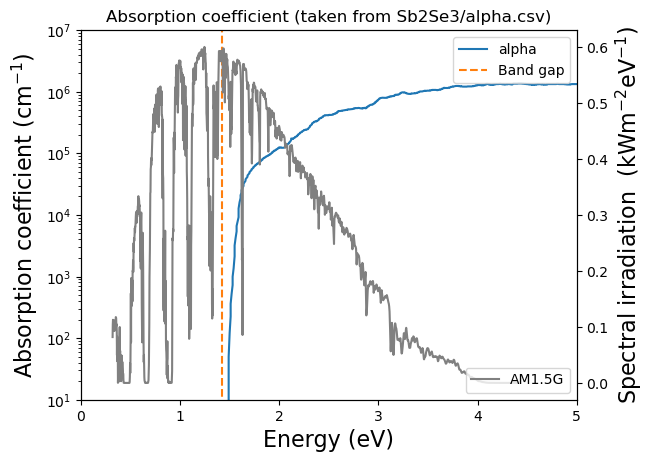

In [15]:
tlc_Sb2Se3.plot_alpha()
plt.xlim((0, 5))

## J-V curve

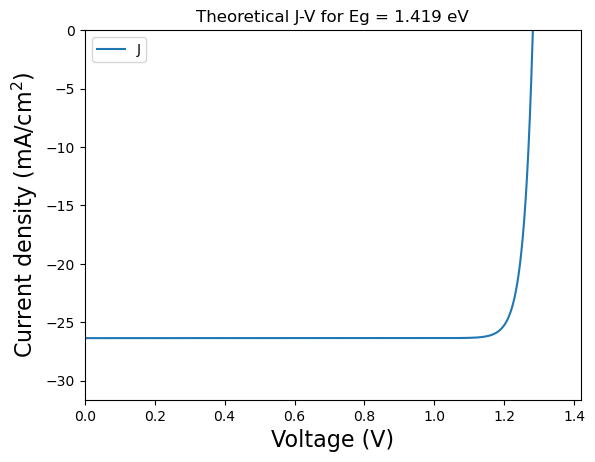

In [16]:
tlc_Sb2Se3.plot_jv()